In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random

In [2]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [8]:
class Kmeans:
    def __init__(self, k, max_iter=100):
        self.k = k
        self.max_iter = max_iter
        self.centroids = None
        self.clusters = None
        self.assignments = None
        self.m = None
        self.d = None

    def fit(self, X):
        """Train the K-Means algorithm on the data X"""
        self.m, self.d = X.shape
        self.centroids = self._init_centroids(X)
        self.assignments = [-1 for _ in range(self.m)]

        for i in range(self.max_iter):
            self.clusters = self._create_clusters(X)
            old_centroids = self.centroids
            self.centroids = self._calculate_centroids(X)
            if self._is_converged(old_centroids):
                break
        return self.assignments

    def _init_centroids(self, X):
        """Initialize the centroids as k random samples from X"""
        return [X[random.randint(0, self.m - 1)] for _ in range(self.k)]

    def _create_clusters(self, X):
        """Assign the samples to the closest centroids to create clusters"""
        clusters = [[] for _ in range(self.k)]
        for idx, sample in enumerate(X):
            centroid_idx = self._closest_centroid(sample)
            self.assignments[idx] = centroid_idx
            clusters[centroid_idx].append(sample)
        return clusters

    def _closest_centroid(self, sample):
        """Return the index of the closest centroid to the sample"""
        distances = [euclidean_distance(sample, point) for point in self.centroids]
        closest_idx = np.argmin(distances)
        return closest_idx

    def _calculate_centroids(self, X):
        """Calculate the new centroids as the means of the samples in each cluster, if the cluster is empty, choose a random sample from X"""
        return [np.mean(cluster, axis=0) if len(cluster) != 0 else X[np.random.randint(self.m - 1)] for cluster in self.clusters]

    def _is_converged(self, old_centroids):
        """Check if the centroids have changed"""
        return np.array_equal(old_centroids, self.centroids)

In [15]:
class PDCDPmeans(Kmeans):
    def __init__(self, l, max_iter=100):
        super().__init__(k=None, max_iter=max_iter)
        self.l = l
        self.j_max = None
        self.d_max = None

    def fit(self, X):
        """Train the K-Means algorithm on the data X"""
        self.m, self.d = X.shape

        self.k = 1
        self.centroids = self._init_centroid(X)
        self.assignments = [0 for _ in range(self.m)]

        for i in range(self.max_iter):
            self.j_max, self.d_max = self.farthest_point(X)
            if not self.split_if_needed(X):
                break
            self.clusters = self._create_clusters(X)
            old_centroids = self.centroids
            self.centroids = self._calculate_centroids(X)
            if self._is_converged(old_centroids):
                break
        return self.assignments

    def _init_centroid(self, X):
        """Initialize the centroid as mean of samples from X"""
        return [np.mean(X, axis=0)]

    def farthest_point(self, X):
        """Return the index, distance of the farthest point from its corresponding centroid"""
        distances = [euclidean_distance(x, self.centroids[self.assignments[idx]]) for idx, x in enumerate(X)]
        farthest_idx = np.argmax(distances)
        return farthest_idx, distances[farthest_idx]

    def split_if_needed(self, X):
        """Split the cluster if the farthest point is farther than l"""
        if self.d_max > self.l:
            self.k += 1
            self.centroids.append(X[self.j_max])
            self.assignments[self.j_max] = self.k
            return True
        return False

In [4]:
# generate  2D data of N = 1000 points using sklearn
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=1)

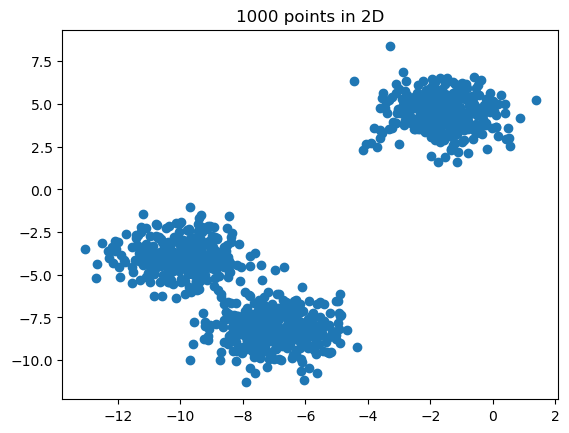

In [5]:
plt.scatter(X[:,0], X[:,1])
plt.title("1000 points in 2D")
plt.show()

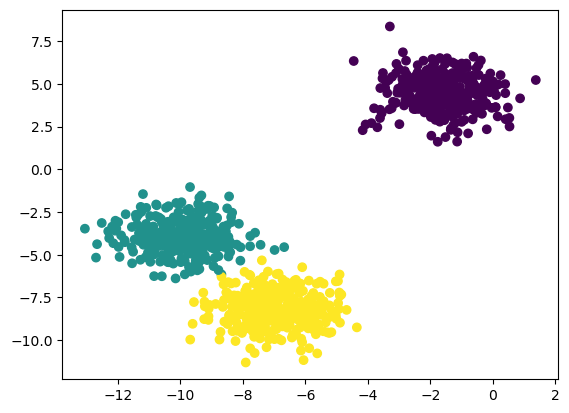

In [9]:
kmeans = Kmeans(k=3)
labels = kmeans.fit(X)
plt.scatter(X[:,0], X[:,1], c=labels)

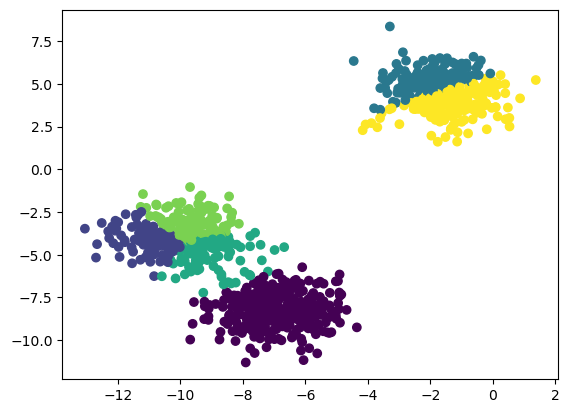

In [13]:
kmeans = Kmeans(k=6)
labels = kmeans.fit(X)
plt.scatter(X[:,0], X[:,1], c=labels)

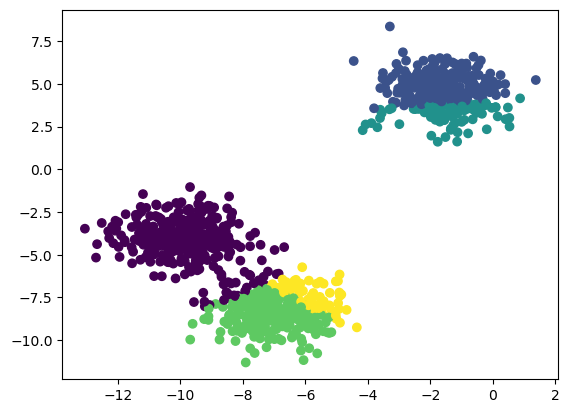

In [19]:
pdc_dp_means = PDCDPmeans(l=4)
labels = pdc_dp_means.fit(X)
plt.scatter(X[:,0], X[:,1], c=labels)

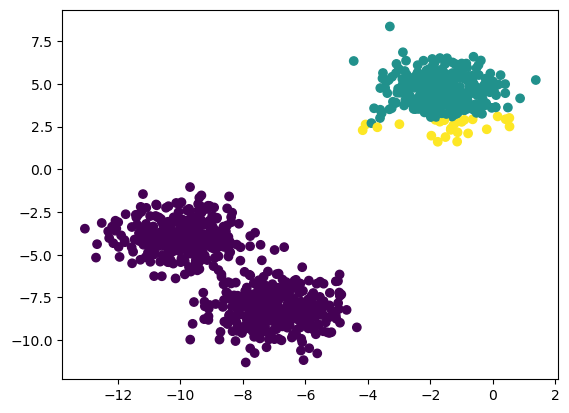

In [20]:
pdc_dp_means = PDCDPmeans(l=6)
labels = pdc_dp_means.fit(X)
plt.scatter(X[:,0], X[:,1], c=labels)

In [ ]:
def calc_avg(Ci, d):
    sum1 = np.zeros((1, d))
    size = len(Ci)

    for x in Ci:
        sum1 += x

    for i in range(d):
        sum1[0][i] = sum1[0][i] / size

    return sum1

In [21]:
def kmeans(X, k, t = 100):
    """
    :param X: numpy array of size (m, d) containing the test samples
    :param k: the number of clusters
    :param t: the number of iterations to run
    :return: a column vector of length m, where C(i) ∈ {1, . . . , k} is the identity of
    the cluster in which x_i has been assigned.
    """
    m = X.shape[0]
    d = X.shape[1]

    # Initialize cluster centroids randomly
    cluster_centroids = [X[random.randint(0, m - 1)] for _ in range(k)]
    cluster_assignments = [-1 for _ in range(m)]

    for _ in range(t):
        # Assign each point to the closest cluster centroid
        cluster_assignments = []
        for x in X:
            distances = [euclidean_distance(x, centroid) for centroid in cluster_centroids]
            # Choose the centroid that minimize the distance from x - Define Ci
            cluster_assignments.append(np.argmin(distances))

        # Recompute the centroids of the clusters
        new_cluster_centroids = []
        for i in range(k):
            Ci = [X[j] for j in range(m) if cluster_assignments[j] == i]  # Build cluster Ci

            if len(Ci) != 0:  # Cluster is not empty
                avg = calc_avg(Ci, d)
                new_cluster_centroids.append(avg)  # avg of samples in the cluster

            else:  # If a cluster is empty, initialize its centroid randomly
                new_cluster_centroids.append(X[np.random.randint(m - 1)])

        # Check if the clusters have changed
        if np.array_equal(new_cluster_centroids, cluster_centroids):
            break

        else:
            cluster_centroids = new_cluster_centroids

    cluster_assignments = np.asarray(cluster_assignments)
    cluster_assignments = cluster_assignments.reshape((m, 1))

    return cluster_assignments


In [21]:
def pdc_dp_means(X, l, t = 100):
    """
    :param X: numpy array of size (m, d) containing the test samples
    :param l: hyperparameter
    :param t: the number of iterations to run
    :return: a column vector of length m, where C(i) ∈ {1, . . . , k} is the identity of
    the cluster in which x_i has been assigned.
    """
    m = X.shape[0]
    d = X.shape[1]
    k = 1

    # Initialize cluster centroids randomly
    cluster_centroids = [calc_avg(X, d)]
    cluster_assignments = [1 for _ in range(m)]

    for _ in range(t):
        # Assign each point to the closest cluster centroid
        cluster_assignments = [np.argmin([euclidean_distance(x, centroid) for centroid in cluster_centroids]) for x in X]
        distances = [euclidean_distance(X[i], cluster_centroids[cluster_assignments[i]]) for i in range(m)]
        j_max = np.argmax(distances)

        try:
            d_max = distances[j_max]
        except IndexError:
            d_max = distances[j_max[0]]

        if d_max > l:
            k += 1
            cluster_centroids.append(X[j_max])
            cluster_assignments[j_max] = k
        else:
            break

        # Recompute the centroids of the clusters
        new_cluster_centroids = []
        for i in range(k):
            Ci = [X[j] for j in range(m) if cluster_assignments[j] == i]  # Build cluster Ci

            if len(Ci) != 0:  # Cluster is not empty
                avg = calc_avg(Ci, d)
                new_cluster_centroids.append(avg)  # avg of samples in the cluster

            else:  # If a cluster is empty, initialize its centroid randomly
                new_cluster_centroids.append(X[np.random.randint(m - 1)])

        # Check if the clusters have changed
        if np.array_equal(new_cluster_centroids, cluster_centroids):
            break

        else:
            cluster_centroids = new_cluster_centroids

    cluster_assignments = np.asarray(cluster_assignments)
    cluster_assignments = cluster_assignments.reshape((m, 1))

    return cluster_assignments
